# Modelo para predecir la demanda de productos

Importamos las librerías necesarias para:
- Conectar a la base de datos.
- Preprocesar los datos.
- Entrenar y evaluar un modelo de Machine Learning.
- Ajustar hiperparámetros.
- Visualizar los resultados.

También cargamos las variables de entorno para acceder a la base de datos de forma segura.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from dotenv import load_dotenv
import os   

In [2]:
load_dotenv()

True

In [3]:
db_url = os.getenv("DATABASE_URL")
engine = create_engine(db_url)

In [4]:
query = """
SELECT 
    v.producto_id,
    v.cantidad,
    v.precio_unitario,
    v.total,
    v.sucursal_id,
    p.categoria,
    p.precio_base,
    t.fecha,
    t.anio,
    t.mes,
    t.dia,
    t.dia_nombre,
    t.mes_nombre
FROM ventas v
JOIN tiempo t ON v.tiempo_id = t.tiempo_id
JOIN productos p ON v.producto_id = p.producto_id;
"""

df = pd.read_sql(query, engine)

print("Datos originales:")
display(df.head())

Datos originales:


,producto_id,cantidad,precio_unitario,total,sucursal_id,categoria,precio_base,fecha,anio,mes,dia,dia_nombre,mes_nombre
0,0000000811,4,468.44,1873.78,69,Abarrotes,430.73,2023-01-01,2023,1,1,Sunday,January
1,0000000538,16,241.69,3866.97,77,Salud,245.49,2023-01-01,2023,1,1,Sunday,January
2,0000000462,5,367.03,1835.14,69,Salud,150.18,2023-01-01,2023,1,1,Sunday,January
3,0000000043,14,28.97,405.60,45,Hogar,386.82,2023-01-01,2023,1,1,Sunday,January
4,0000000712,11,345.73,3803.04,91,Salud,64.21,2023-01-01,2023,1,1,Sunday,January


Convertimos los datos a los tipos adecuados y creamos nuevas características:
- `es_fin_de_semana`: Indica si la venta ocurrió en sábado o domingo.
- `es_mes_alto`: Indica si la venta ocurrió en noviembre o diciembre (meses con mayor demanda).

También aplicamos **One-Hot Encoding** para convertir variables categóricas en valores numéricos.

In [5]:
df["producto_id"] = df["producto_id"].astype(int)
df["sucursal_id"] = df["sucursal_id"].astype(int)
df["cantidad"] = df["cantidad"].astype(int)
df["precio_unitario"] = df["precio_unitario"].astype(float)
df["total"] = df["total"].astype(float)
df["precio_base"] = df["precio_base"].astype(float)
df["fecha"] = pd.to_datetime(df["fecha"])

In [6]:
df["es_fin_de_semana"] = df["dia_nombre"].isin(["Saturday", "Sunday"]).astype(int) 
df["es_mes_alto"] = df["mes"].isin([11, 12]).astype(int) 

In [7]:
df = pd.get_dummies(df, columns=["dia_nombre", "mes_nombre", "categoria"], drop_first=True)

In [8]:
print("\nDatos después del procesamiento:")
display(df.head())


Datos después del procesamiento:


,producto_id,cantidad,precio_unitario,total,sucursal_id,precio_base,fecha,anio,mes,dia,...,mes_nombre_June,mes_nombre_March,mes_nombre_May,mes_nombre_November,mes_nombre_October,mes_nombre_September,categoria_Electrónica,categoria_Hogar,categoria_Ropa,categoria_Salud
0,811,4,468.44,1873.78,69,430.73,2023-01-01,2023,1,1,...,False,False,False,False,False,False,False,False,False,False
1,538,16,241.69,3866.97,77,245.49,2023-01-01,2023,1,1,...,False,False,False,False,False,False,False,False,False,True
2,462,5,367.03,1835.14,69,150.18,2023-01-01,2023,1,1,...,False,False,False,False,False,False,False,False,False,True
3,43,14,28.97,405.60,45,386.82,2023-01-01,2023,1,1,...,False,False,False,False,False,False,False,True,False,False
4,712,11,345.73,3803.04,91,64.21,2023-01-01,2023,1,1,...,False,False,False,False,False,False,False,False,False,True


Se hace la definición de variables de entrada y salida: 
- `X`: Variables predictoras, eliminamos "cantidad" (la variable objetivo) y "fecha" (ya desglosada).
- `y`: Variable objetivo, que representa la cantidad de productos vendidos.

Finalmente, dividimos los datos en **entrenamiento (80%)** y **prueba (20%)**.

In [9]:
X = df.drop(columns=["cantidad", "fecha"])
y = df["cantidad"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Para encontrar la mejor combinación de hiperparámetros para XGBoost, probamos diferentes valores de:
- `n_estimators`: Número de árboles en el modelo.
- `learning_rate`: Tasa de aprendizaje.
- `max_depth`: Profundidad máxima de los árboles.

Usamos `GridSearchCV` con validación cruzada (`cv=3`) para seleccionar el mejor modelo.

In [11]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

Entrenamos el modelo con los mejores hiperparámetros encontrados y realizamos predicciones sobre el conjunto de prueba.

In [12]:
grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=3, verbose=1, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [13]:
modelo = grid_search.best_estimator_

In [14]:
y_pred = modelo.predict(X_test)

Calculamos las siguientes métricas para medir el desempeño del modelo:
- **MAE (Mean Absolute Error):** Promedio de los errores absolutos.
- **RMSE (Root Mean Squared Error):** Raíz cuadrada del error cuadrático medio.
- **R² Score:** Indica qué tan bien el modelo explica la variabilidad de los datos (valor cercano a 1 es mejor).

Se comparan las métricas en el conjunto de entrenamiento y prueba para detectar **sobreajuste**.

In [15]:
y_train_pred = modelo.predict(X_train)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = root_mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f"🔹 MAE (Train): {mae_train} | MAE (Test): {mae}")
print(f"🔹 RMSE (Train): {rmse_train} | RMSE (Test): {rmse}")
print(f"🔹 R² (Train): {r2_train} | R² (Test): {r2}")

🔹 MAE (Train): 0.05598673678805941 | MAE (Test): 0.06141703772246643
🔹 RMSE (Train): 0.11783414669861583 | RMSE (Test): 0.1492006084425986
🔹 R² (Train): 0.9995372295379639 | R² (Test): 0.9992589354515076


Aplicamos **validación cruzada de 5 folds** para evaluar la estabilidad del modelo.  

In [16]:
cv_scores = cross_val_score(modelo, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"🔹 Cross-Validation MSE: {cv_scores}")
print(f"🔹 Mean Cross-Validation Score: {cv_scores.mean()}")

🔹 Cross-Validation MSE: [-0.02228239 -0.0223779  -0.02248552 -0.02153246 -0.02240833]
🔹 Mean Cross-Validation Score: -0.022217320526981922



Se genera un gráfico de dispersión para comparar las **predicciones vs valores reales**.  
La línea roja representa la predicción ideal (valores reales = predicciones).

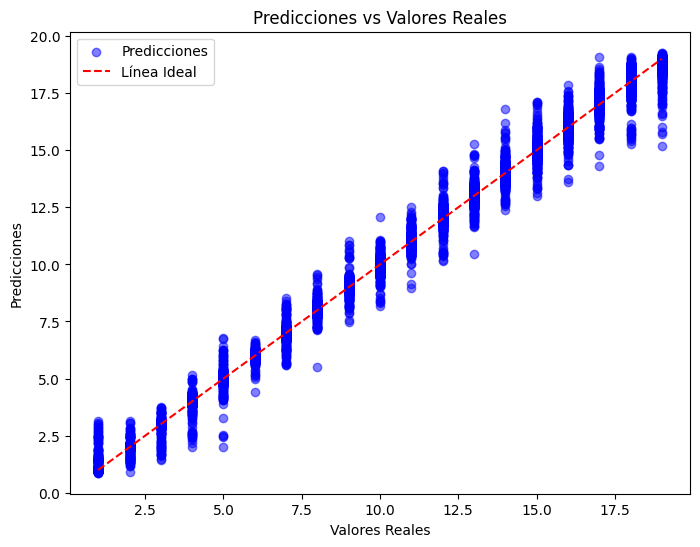

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicciones", color="blue")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='dashed', color='red', label="Línea Ideal")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales")
plt.legend()
plt.show()

In [18]:
#Guardar el modelo en formato JSON
modelo.save_model("model.json")